<center><h1> Dirichlet Process Mixture Models </h1></center>
<br>
<br>
<br>
<center><b>Guilherme Pires</b></center><br>
<center>Instituto Superior Técnico - 2016/2017</center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction

In this work I'll try to present the concept of Dirichlet Process and to show how they can be used to 
implement Infinite Mixture Models. I'll start by introducing the Dirichlet Distribution, the Dirichlet 
Process, and the application of the Dirichlet Process to Infinite Mixture Models. I'll then apply an implementation
of this model to the clustering of data, with an unknown number of clusters.

# Dirichlet Distribution

## An introduction

The Dirichlet Distribution is commonly used as the conjugate prior for the Multinomial distribution. This means
that for a Multinomial likelihood model, the most natural/simple way to encode our prior beliefs about the nature
of the observations is by using a Dirichlet distribution. Not only that, if we use a Dirichlet prior with a
Multinomial likelihood, the posterior will turn out to be a Dirichlet distribution as well (obtained by updating the $\boldsymbol\alpha$ parameter's entries with the corresponding counts given by the Multinomial observations).

Let $$\begin{eqnarray}
\boldsymbol\theta &=& (\theta_1 , \theta_2, ..., \theta_m) \nonumber\\
\boldsymbol\alpha &=& (\alpha_1 , \alpha_2, ..., \alpha_m)
\end{eqnarray}$$ 
Then $$\boldsymbol\theta \sim Dir(\boldsymbol\alpha) : 
P(\boldsymbol\theta)=\frac{\Gamma(\sum_{k}^{m} \alpha_k)}{\prod_{k}^{m}\Gamma(\alpha_k)}\prod_{k}^{m}\theta_{k}^{a_k -1}$$

Note that samples $\boldsymbol\theta$ from the Dirichlet Distribution belong to the probability simplex, which
means $\sum_{k}^{m}\theta_k = 1, \theta_k \geq 0$

The Dirichlet Distribution can be regarded as a distribution over possible parameters for a Multinomial
Distribution - which is the intuitive reason to use the former as the latter's prior. Extending this notion a 
bit further, we can regard the Dirichlet Distribution as a distribution over (Multinomial) distributions.

## The $\boldsymbol\alpha$ effect
Let's look at the effect of the $\boldsymbol\alpha$ parameter on the shape of the distribution. For simplicity, lets take $m=3$. The simplex of the corresponding space is a triangle and so it can be projected to 2D and be easily plotted.

In [3]:
from scipy.stats import dirichlet as Dir

ortog = (1/np.sqrt(3)) * np.ones(3)

x = np.array([1,0,0])
x = x - np.dot(x, ortog) * ortog
x /= np.linalg.norm(x)
y = np.cross(ortog, x)

def project3dsample(sample):
    return np.array([np.dot(sample, x), np.dot(sample, y)])

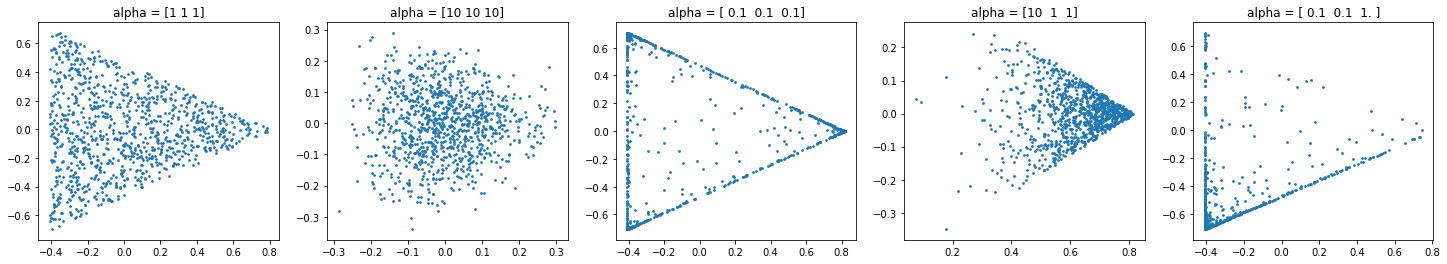

In [7]:
fig, axs = plt.subplots(1,5, figsize=(25,4))

alphas = [
    np.array([1,1,1]),
    np.array([10,10,10]),
    np.array([0.1,0.1,0.1]),
    np.array([10,1,1]),
    np.array([0.1,0.1,1])
]
    
for alpha, ax in zip(alphas, axs):
    samples = np.array([project3dsample(sample) for sample in Dir.rvs(alpha, size=1000)])
    ax.set_title("alpha = {}".format(alpha))
    ax.scatter(samples[:,0], samples[:,1], s=3);
    
plt.show()

We see that $\boldsymbol\alpha$ controls the nature of the probability vectors sample from the Dirichlet
Distribution:
- If the $\alpha_i$ are all equal to $\alpha$, the resulting samples have a symmetric spread on the space. More particularly:
    - If $\alpha = 1$, the samples spread uniformely on the space
    - If $\alpha \gt 1$, dense (as in opposed to sparse) samples are more frequent
    - If $\alpha \lt 1$, sparse samples are more frequent
- If the $\alpha_i$ are not equal, there will be either a concentration on either one of the vertices or one
of the edges of the space

---

# Dirichlet Process

## Introduction to the concept

The Dirichlet Process can be regarded as a generalization of the the Dirichlet Distribution to 
infinite dimensions. It too defines a distribution over distributions. However, while the Dirichlet Distribution
defines a distribution over random probability measures of defined dimension, the Dirichlet Process defines a
distribution over random probability measures, of random dimension.
 
Formally:

- Consider the measure space defined by $(\Theta, \Sigma)$, where $\Theta$ is some set and $\Sigma$ is a 
$\sigma$-algebra on $\Theta$
- Take a *measurable finite partition* of $\Theta$ : $A_1, A_2, ..., A_k$
- A Dirichlet Process is a random probability measure $G$ over a measure space $(\Theta, \Sigma)$, that respects a special property:
    - $[G(A_1), G(A_2), ..., G(A_3)] \sim Dir(\alpha H(A_1), \alpha H(A_2), ..., \alpha H(A_k))$
- The Dirichlet Process is parametrized by:
    - $\alpha \in \mathbb{R}$ : The concentration parameter
    - $H$ (a probability distribution): The base distribution
- Most common notation: $G \sim DP(\alpha, H)$

Intuitively, $H$ is the mean distribution" and $\alpha$ can be regarded as an "inverse variance". A sample from
a Dirichlet Process will be an infinite sum of Dirac deltas, with different heights, and with locations sampled
from $H$.

A somewhat counter-intuitive fact is that a sample $G$ from a Dirichlet Process will be discrete with probability
1, even if the base distribution is smooth. Even so, the base distribution will be the mean distribution! 

## Posterior Inference

Now suppose we use a (random) sample $G$ from a $DP$ as a likelihood model for some i.i.d data 
$\theta_1, \theta_2, ..., \theta_N$ : $\theta_n | G \sim G$.

Convenientely, the conjugacy of the Dirichlet Distribution to the Multinomial Distribution still applies to the
Dirichlet Process, which means the posterior on $G$ is also a Dirichlet Process and is given (after some
rather cumbersome algebraic manipulation) by:
$$ G | \theta_1, \theta_2, ..., \theta_N \sim DP(\alpha+N , \frac{\alpha H + \sum_{n=1}^{N}\delta_{\theta_n}}{\alpha+N}) $$

Where $\delta_{\theta_n}$ is the Dirac delta function. (Note that some of the $\theta_n$ will fall on the same value, which means we'll have summed $\delta$'s. A reasonable and intuitive way of thinking about these, is as the counts of sampled $\theta$ that fell on each value (which hints at the empirical distribution).

The posterior predictive distribution of a DP is given by its base distribution. Taking that fact, we see that 
the posterior predictive distribution for $\theta_{N+1}$ is:
$$\theta_{N+1} | \theta_1, ..., \theta_N \sim \frac{\alpha H + \sum_{n=1}^{N}\delta_{\theta_n}}{\alpha+N}$$

If you look carefully at that distribution, you'll see it has a smooth part and a discrete part.
It could look similar to this:

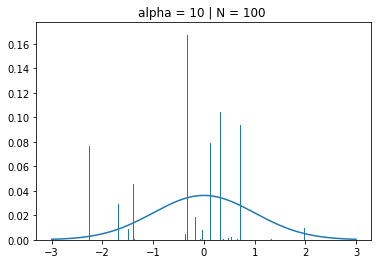

In [25]:
from scipy.stats import beta
from scipy.stats import norm

def predictive_posterior_plot(N, alpha, ax):
    stick = 1
    pis = []
    for i in range(N):
        pi = stick * beta.rvs(1, alpha)
        pis.append(pi)
        stick -= pi
    
    pis = np.array(pis)*N/(alpha+N)
    thetas = norm.rvs(size=N)
    x = np.array(range(-3000,3000))*0.001
    y = norm.pdf(x)*alpha/(alpha+N)

    ax.set_title("alpha = {} | N = {} ".format(alpha, N))
    ax.plot(x,y)
    ax.set_ylim((0,max([max(pis),max(y)])+0.01))
    ax.bar(thetas,pis,0.01)

fig, ax = plt.subplots()
predictive_posterior_plot(100,10,ax)
plt.show()

That's rather unintuitive - how do you sample from such a distribution? Hopefully the next section will
make that clearer.

### Chinese Restaurant Process and Polya Urn Process

Two very famous representations for the Dirichlet Process have been devised, that evidence its clustering properties, in a *rich get richer* fashion. They are the Chinese Restaurant Process, and the Polya Urn Process. 
Put simply, they provide a way to "implement" the posterior predictive distribution I just presented, by either:
- Assigning points to an existing group, with some probability
    - Which corresponds to assigning a person who just entered the restaurant to one of the existing tables, 
    in the Chinese Restaurant Process
    - And to add to the urn a ball of the same color as some other ball sampled from the urn, 
    in the Polya Urn Process
- Create a new group, based on the new point
    - Which corresponds to assingning a person who just entered the restaurant to an empty table,
    in the Chinese Restaurant Process
    - And to add a ball of a new color to the urn,
    in the Polya Urn Model
    
This somewhat "dual" behaviour is evidenced by the posterior predictive distribution, especially if we separate the expression in two terms:
$$\theta_{N+1} | \theta_1, ..., \theta_N \sim \frac{\alpha}{\alpha+N}H + 
\frac{N}{\alpha+N}(\frac{1}{N}\sum_{n=1}^{N}\delta_{\theta_n})$$

This way of writing the equation evidences the fact that the posterior predictive distribution is a weighted sum
of the base distribution and the empirical distribution. How does one sample from such a distribution?
- With probability $\frac{\alpha}{N+\alpha}$ we sample the next $\theta$ from the base distribution, $H$
- With probability $\frac{N}{N+\alpha}$ we sample the next $\theta$ from the empirical distribution

As it is easy to see, as N increases (i.e. we see more data), the weight of the base distribution becomes 
proportionally smaller - proper Bayesian behaviour! - but the probability of a new (as in *previously 
unseen*) value for $\theta$ is never $0$. We can also see that the concentration parameter will have control
over the final number of clusters: the bigger $\alpha$ is, the likelier the predictive distribution is to sample
a new $\theta$ value from the base distribution. That can easily be observed by the following plots.

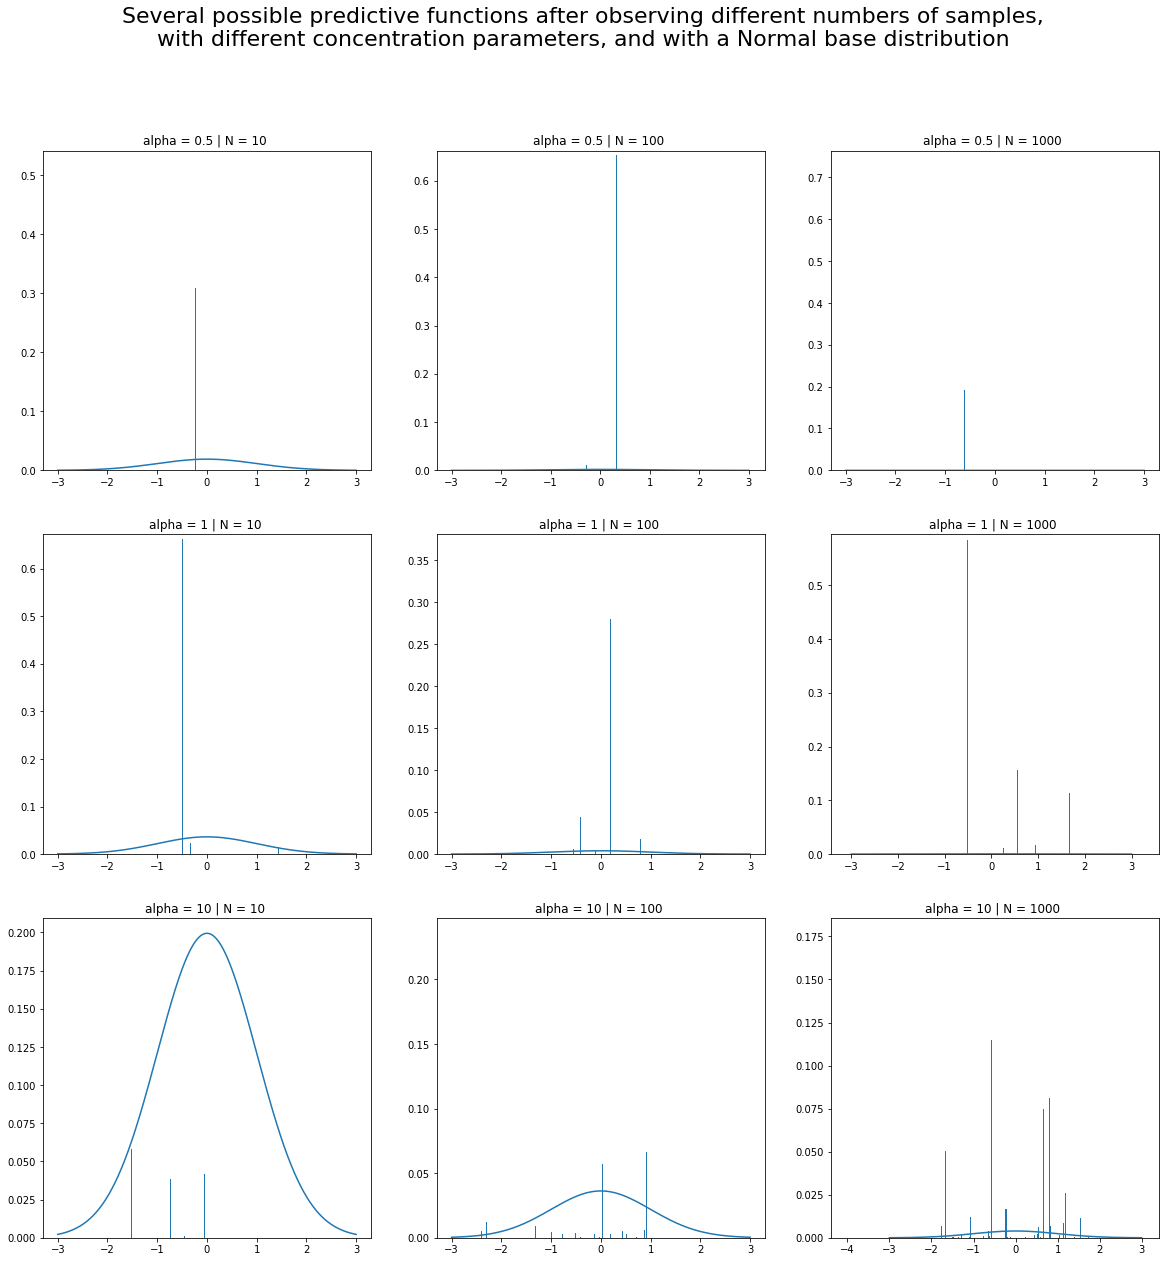

In [26]:
import itertools
   
fig, axs = plt.subplots(3,3, figsize=(20,20))

alphas = [0.5, 1, 10]
Ns = [10, 100, 1000]
axs = axs.flatten()

for (ax, (alpha, N)) in zip(axs, itertools.product(alphas, Ns)):
    predictive_posterior_plot(N, alpha, ax)

plt.suptitle("Several possible predictive functions after observing different numbers of samples,\n"+
             "with different concentration parameters, and with a Normal base distribution", fontsize=22)
plt.show()

We can see these plots are coherent with the intuitive notion I hinted at: for a fixed number of observed samples,
a bigger $\alpha$ increases the weight of the base distribution; for a fixed $\alpha$, a bigger number of samples
decreases the weight of the base distribution.

### Stick Breaking Representation

A third, more generative view of the DP, called the Stick Breaking Representation allows us to obtains 
samples $G$ from a Dirichlet Process. It's important to keep in mind that samples $G$ from a DP are themselves
probability distributions! The Stick Breaking Representation obtains samples $G \sim DP(\alpha, G)$ by the
following process:

- Take a stick of length 1   
- While remaining_stick has length > 0:   
    - Sample a $\pi_k$ from $Beta(1,\alpha)$
        - Note that $\pi_k \in [0,1]$ 
    - Break the remaining stick at $\pi_k$ of it's length   
    - current_stick = first part, remaining_stick = second part   
    - Sample a $\theta_k$ from $H$
    - Place a $\delta_{\theta_k}$ with height = current_stick on point $\theta_k$

We see that in the end of this process, G will be equal to $\sum_{k=1}^\infty \delta_k \pi_k$ .

## An intuitive bridge to (Infinite) Mixture Models

The usefulness of the DP in mixture models now starts to become apparent. We can easily use the random 
variables $\theta_k$ as the latent "indexing" variables on a mixture model, taking advantage of the natural
clustering behaviour of the DP and also of the fact that, at any point, it allows the possibility of seeing
a new value for $\theta_k$ - hence the proneness to model a Mixture Model with an unknown number of components:
a new one can appear at any time, if the data so suggests. 

Systematizing the Dirichlet Process Mixture Model:
$$\begin{eqnarray}
G|\alpha, H &\sim& DP(\alpha, H) \nonumber \\
\theta_n|G &\sim& G \nonumber \\
x_n|\theta_n &\sim& F(\theta_n) \nonumber \\
\end{eqnarray}$$

Where $F(\theta_n)$ is a class conditional distribution, e.g., a Gaussian in the case of a Gaussian Mixture Model.

One of the biggest motivations to use this kind of models lies in its ability to directly attack the problem
of model selection: there is no initial assumption on the number of components, and the model itself "searches"
 for the best possible.

---

# Inference in DPMM

Several ways of doing Inference on Dirichlet Process Mixture Models have been proposed and shown. 
The most common ones involve Gibbs Sampling, Collapsed Gibbs Sampling or other MCMC or simulation methods. 
More recently some Variational methods have also been proposed. I will present an overview of both approaches,
also introducing the high-level basics of Gibbs Sampling and Variational Inference.

Both of these approaches come from the need of computing complex (as in *complicated and hard*) integrals (usually on the denominators of posterior distributions). Gibbs Sampling tackles this by sampling from distributions that 
assymptotically approach the true ones, while Variational methods work by converting the integral computation into
an optimization problem.

## Gibbs Sampling approach

### Gibbs Sampling

As mentioned, Gibbs Sampling takes the approach of sampling from a distribution that is assymptotically similar to
the one of interest. It is an instance of a broader class of sampling methods, called Markov Chain Monte Carlo.

It's clear that if we had a black box from which we could take samples of the distribution we care about, we could
empirically estimate that distribution. However, how can you build a black box for a distribution you don't know
yet?

First, there's the need to realize that what we actually want is to compute something in the form of:
$$E_{p(z)}[f(z)]=\int_{z}f(z)p(z)$$
Where $p(z)$ governs the distribution of the values of $z$, but the integral we're actually interested is on
the values of $f(z)$. Consider the previous expression in this form:
$$E_{p(z)}[f(z)]=\lim_{N \to \infty}\frac{1}{N}\sum_{N}f(z_{(i)})$$

Where $z_{(i)}$ are observed values, taken from the $p(z)$ distribution. Here we're counting how many times $f(z)$
landed on a particular value and averaging it. So what we really want is to have a way to "tell" how much time we
spent on each "region" of the $z$-space sow that we can accumulate $f(z)$ values. A way to do so is to use a Markov
Chain that allows us to visit each $z$-value with a frequency proportional to $p(z)$ - hence the name Markov Chain Monte Carlo.

Gibbs Sampling is a way to implement such a Markov Chain. It's only applicable when the $z$-space has at least 2
dimensions. It works by getting each dimension of the next $z$-point individually, conditioned on the remaining
dimensions. For our models, these dimensions will be parameters and variables.

Gibbs Samplers are derived on a per-model basis, because the way we sample a new value for a dimension is 
determined by the way these dimensions relate "interact" in the model.

### Collapsed Gibbs Sampling

Collapsed Gibbs Sampling takes the same principals from *Vanilla* Gibbs Sampling, but does the sampling of new
dimension values with some of the dimensions integrated out. This is made possible in some models due to prior 
conjugacy and some algebraic tricks, and it makes the sampler quicker because it reduces the number of variables 
per sampling operation.

### Gibbs Sampling for DPMM

Several Gibbs Samplers have been devised for Dirichlet Process Mixture Models. Although I'm not going to derive
one here, I'll link some references on that.

## Variational approach

### Variational Inference and Variational Bayes

Variational Inference works by transforming the problem of integration into one of optimization. It does so
by fully replacing the distribution we want to compute with an approximation which is chosen to live inside of
a distribution family. This family is commonly called a Variational Family, and it doesn't necessarily include
the real distribution (actually, most likely it won't include the real distribution). Variational Inference then
proceeds by finding the parameters that correspond to the optimal distribution in the Variational Family.

The question that should be ringing in your head now is: "Optimal regarding what?". The answer is: We optimize 
the parameters so as to minimize the Kullback-Leibler divergence between the true distribution and the 
approximation. The KL divergence is a measure of how different two distributions are. It's got its roots in
Information Theory, and it can be interpreted as the number of extra bits (if we work with base 2 logarithms)
needed to encode an information source distributed according to $p$, if we use $q$ to build our codebook.

A side note: the KL divergence is **not** symmetric, i.e., $KL(p||q)
\neq KL(q||p)$; in [] Murphy suggests that the reverse version of the KL is statistically more sensible, but I
won't go into details on why that is. For the purpose of this overview, it suffices to know that choosing to
optimize for the forward KL divergence will yield different results than choosing to optimize for the reverse KL
divergence.

Back on track. How does on go about computing the KL divergence between two distributions without knowing one
of them? The distribution we don't know is precisely that which we want to estimate. It seems we got stuck on 
an infinite loop. Alas! The whole trick of Variational Inference is the way to break this loop. It turns out
there's a way to leverage some probability equalities and Jensen's inequality to come up with an expression,
called the Expectation Lower Bound, ELBO. Maximizing this expression is equivalent to minimizing the KL divergence
without needing to know a closed form for $p(x)$. Here's the derivation of that result:

Consider Jensen's inequality (applied to Expectation):
$$f(E[X]) \geq E[f(X)]$$

Applying it to the log-probability of the observations:
$$\begin{eqnarray}
log\ p(x) &=& log \int_z p(x,z) dz \nonumber \\
&=& log \int_z p(x,z)\frac{q(z)}{q(z)} dz \nonumber \\
&=& log E_q[\frac{p(x,Z)}{q(z)}] \nonumber \\
&\geq& E_q[log\ p(x,Z)] - E_q[log\ q(Z)] \nonumber\\ 
\end{eqnarray}$$

Our goal is now to find the parameters that yield the $q(Z)$ distribution that makes this bound as tight as possible. One of the advantages of Variational methods as compared to sampling methods is the fact that this
optimization yields deterministic results, and Variational methods are faster in general. However there's
usually an accuracy trade-off.

You might have noticed that the title for this section includes "Variational Bayes". This refers to the application
of Mean-Field Variational Inference, where the Variational distribution is of the form $\prod_i q_i(x_i)$

### Streaming Variational Bayes and DPMM

Streaming Variational Bayes is a framework by *Broderick, et al.* that proposes a way to leverage the conjugacy of some distributions
to allow the fitting of the approximation to be computed in a streaming fashion - which aligns with the current
tendencies of big-data and scalability. This framework has been leveraged by *Huynh et al.* to apply Variational
Inference to Dirichlet Process Mixture Models.

---

# Experiments

I used the BayesianGaussianMixture implementation from [scikit-learn](scikit-learn.org) to find clusters
of countries with similar living standards. [Here](http://www.sharecsv.com/s/4165c9b03d9fffdef43a3226613ff37c/Countries.csv) is the dataset I used.

In [68]:
import pandas as pd
df = pd.read_csv("./Countries.csv")
df.head()

,Country,Name,GDPPC,Literacy,InfantMortality,Agriculture,Population,NetMigration
0,1,Albania,3965,0.987,14.0,0.227,3038594,-3.3
1,2,Algeria,4206,0.800,27.7,0.107,39670000,-0.9
2,3,Andorra,42500,1.000,3.6,0.006,86165,0.0
3,4,Angola,4102,0.711,76.5,0.050,25020000,-0.1
4,5,Anguilla,8800,0.950,3.4,0.029,15000,11.9


In [69]:
cols_of_interest = ["GDPPC", "Literacy", "InfantMortality", "Agriculture", "Population", "NetMigration"]

In [70]:
y = df[cols_of_interest].values

In [71]:
from sklearn.mixture import BayesianGaussianMixture

m = BayesianGaussianMixture(
    n_components=5, 
    weight_concentration_prior=1/5, #alpha
    weight_concentration_prior_type="dirichlet_process",
    max_iter=10000,
    init_params="random"
)

m.fit(y)
preds = m.predict(y)
print(np.bincount(preds))

[65  4 24 50 27]


In [72]:
grouped = dict(zip(range(0,100), [list() for _ in range(0,100)]))

for i in range(len(preds)):
    grouped[preds[i]].append(df.iloc[i]["Name"])

to_del = []
for key in grouped:
    if len(grouped[key]) == 0:
        to_del.append(key)

for key in to_del:
    del grouped[key]

In [73]:
from sklearn.preprocessing import MinMaxScaler

for col in cols_of_interest:
    if col != "NetMigration":
        df[col] = MinMaxScaler(feature_range=(0,1)).fit_transform(df[col].values.reshape(-1,1))
    else:
        df[col] = MinMaxScaler(feature_range=(-1,1)).fit_transform(df[col].values.reshape(-1,1))

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [74]:
def plot_country(ax, country, cluster_key=None):
    x = np.arange(len(cols_of_interest))
    
    if cluster_key != None:
        rows = df.loc[df["Name"].isin(grouped[cluster_key])][cols_of_interest].values
        y = np.mean(rows, axis=0)
        country = "Cluster {} average".format(cluster_key)
        ax.set_yticks(x)
        ax.set_yticklabels(cols_of_interest, fontsize=22)
        color="orange"
    else:
        y = df.loc[df["Name"] == country][cols_of_interest].values.flatten()
        ax.tick_params(axis="y", which="both", left="off", right="off", labelleft="off")
        color="blue"
        
    ax.tick_params(axis="x", which="both", bottom="off", top="off", labelbottom="off")
    ax.set_title(country, fontsize=22)
    ax.barh(x, y, height=0.3, alpha=0.65, color=color)
    
    
def plot_cluster(axs, key):
    countries = np.random.choice(grouped[key], size=3, replace=False)
    for ax, country in zip(axs[1:4], countries):
        plot_country(ax, country)
    plot_country(axs[0],"", key)

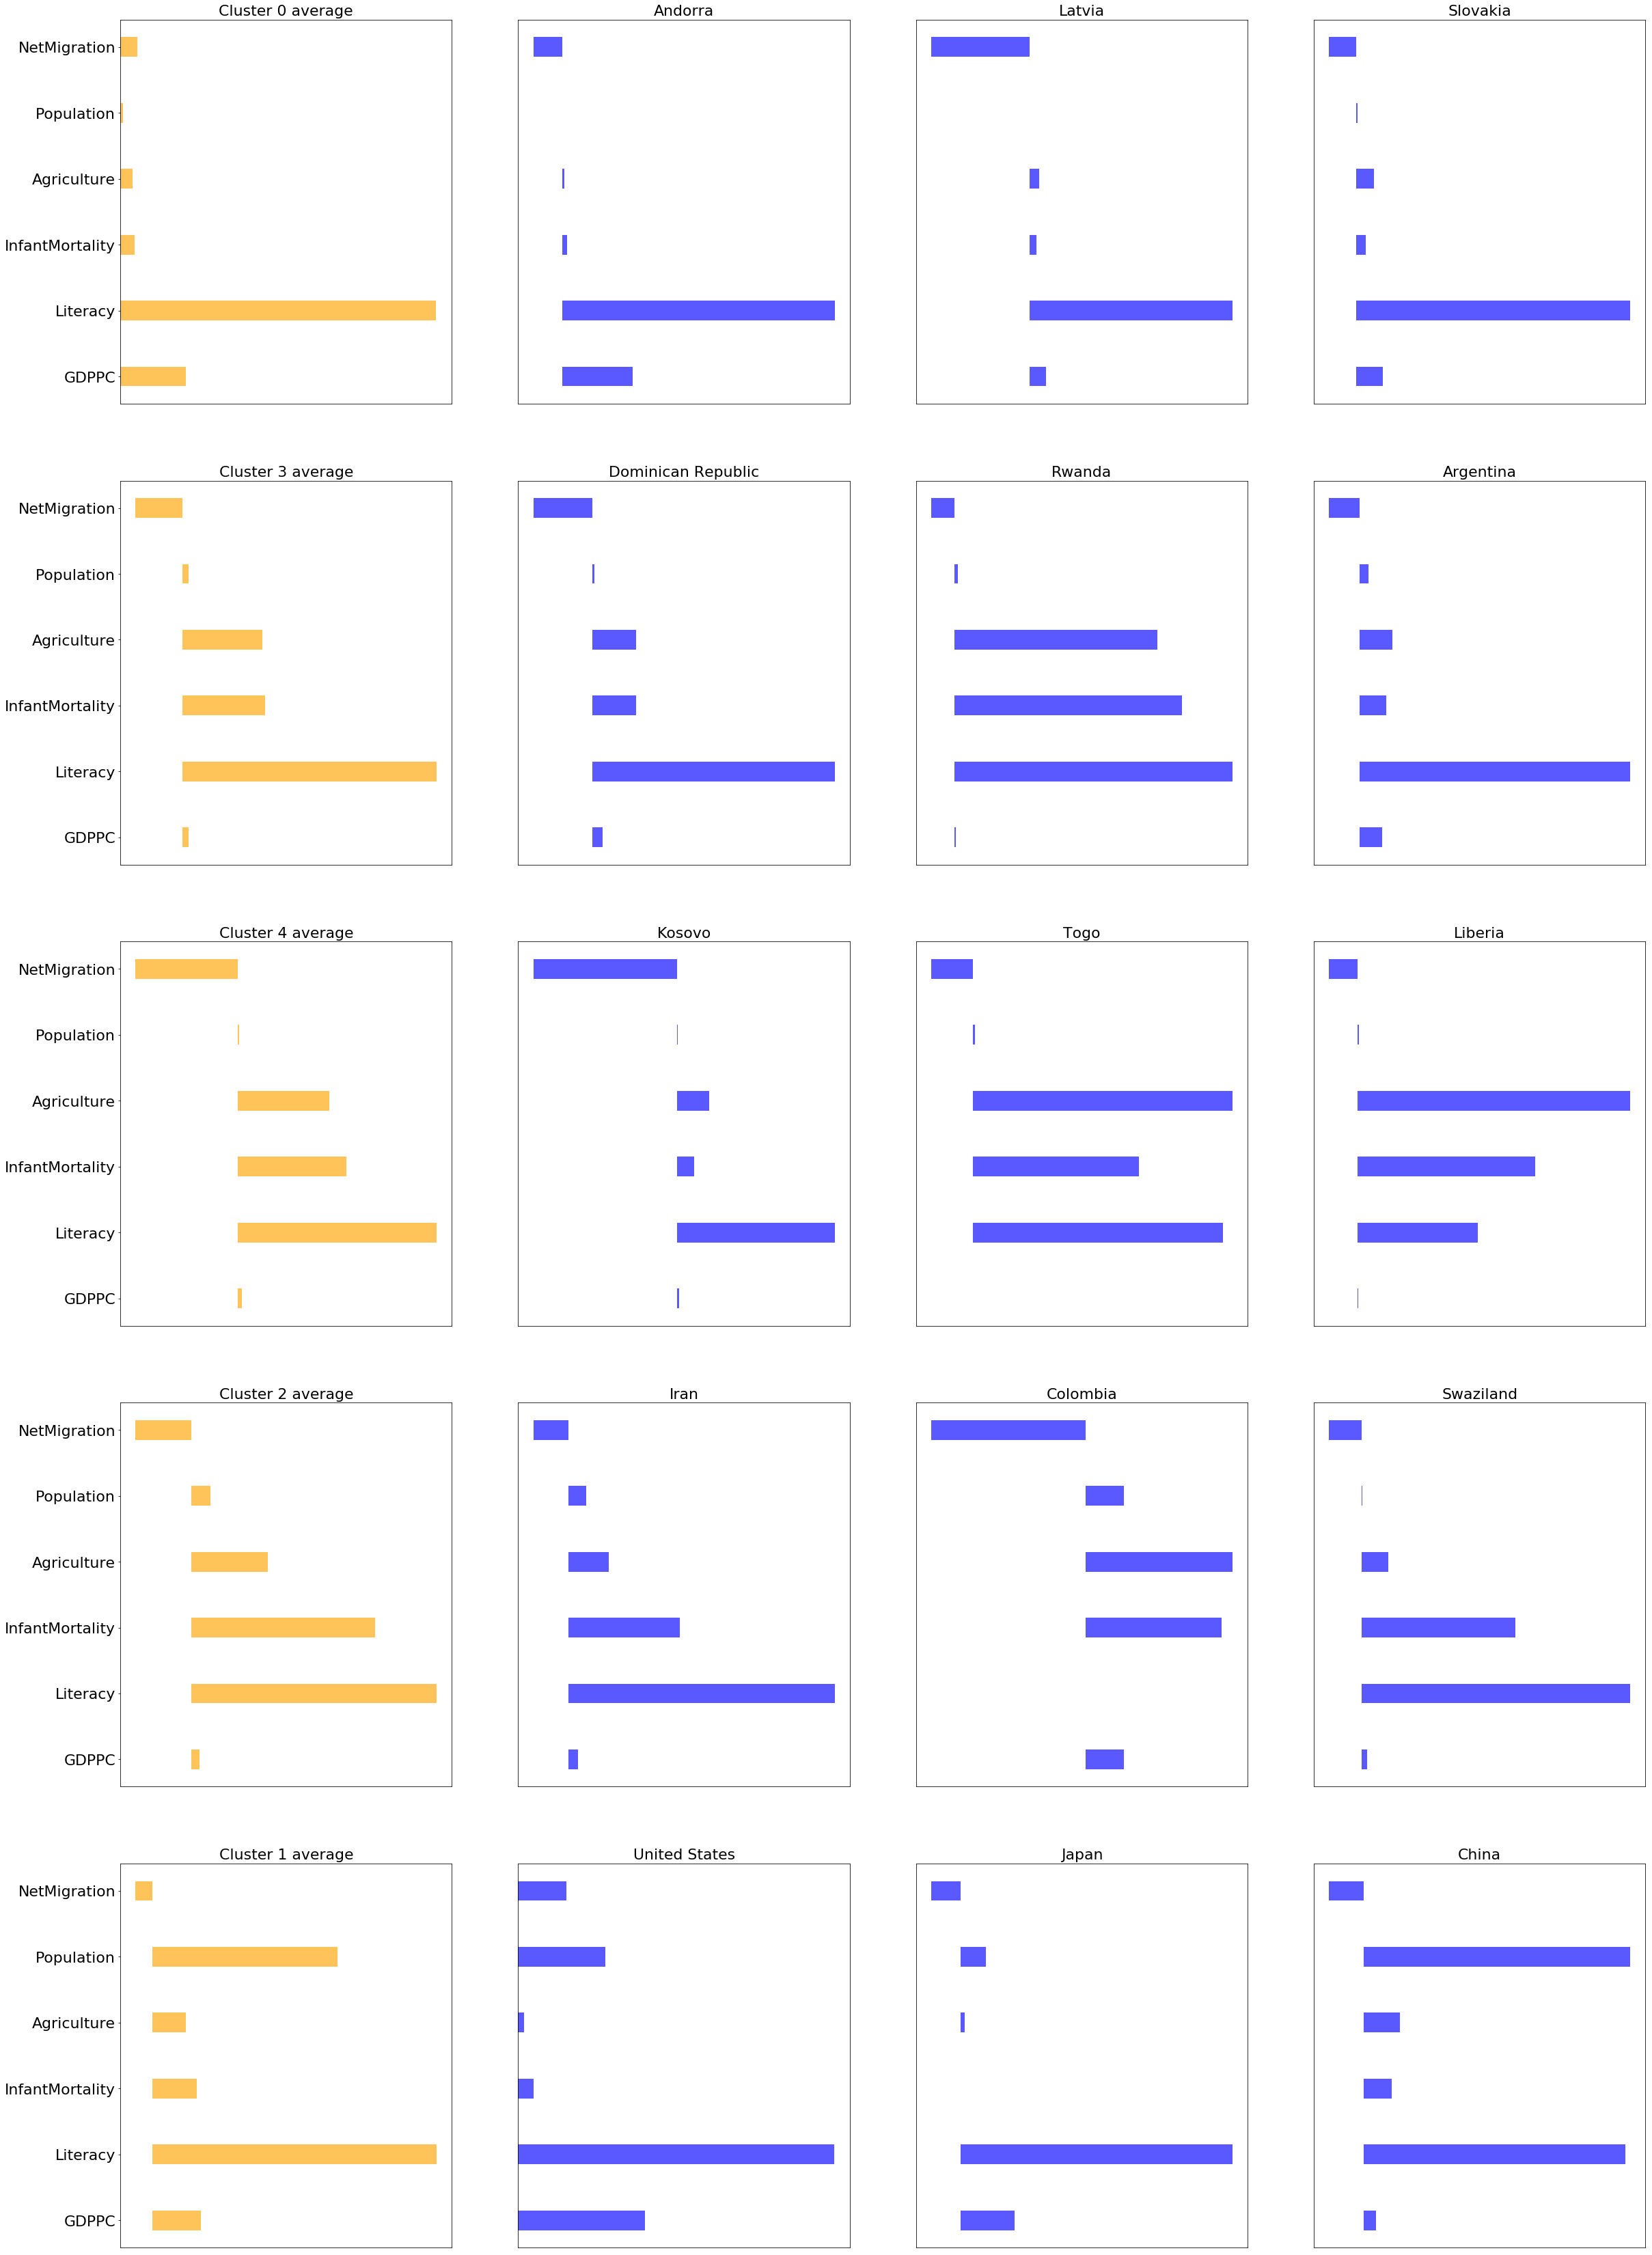

In [84]:
fig, axs_ = plt.subplots(5,4,figsize=(40,60))

top_5 = sorted(grouped.items(), key=lambda x: len(x[1]), reverse=True)[:5]

for (cluster,_), axs in zip(top_5, axs_):
    plot_cluster(axs, cluster)
    
plt.show() 

---

# Proposals for future research

One direction of research I feel tempted to follow is the application of Neural Variational Inference as an
alternative to classic Variational Inference and MCMC methods for fitting Dirichlet Process Mixture Models.
Neural Variational Inference has been applied with particular success to language modelling and other text
processing tasks - which are areas where DPMM are traditionally applied (for instance in Latent Dirichlet
Allocation) - and it aligns with the current trend of leveraging Deep Learning. Adversarial Networks have
also been used with good results to model complex probabilistic distribution, so perhaps applying them to DPMMs
can also be an interesting research premise.

---

# References

[1] [R. Adams.  Bayesian Nonparametrics Tutorial](http://rp-www.cs.usyd.edu.au/~mlss/content/mlss2015-adams.pdf)    
[2] [Y. W. Teh. Dirichlet Process](http://www.gatsby.ucl.ac.uk/~ywteh/research/npbayes/dp.pdf)    
[3] K. Murphy. *Machine Learning: a Probabilistic Perspective       *   
[4] [V. Huynh, D. Phung, S. Venkatesh. Streaming Variational Inference for Dirichlet Process Mixtures](http://proceedings.mlr.press/v45/Huynh15.pdf)   
[5] [T. Broderick, N. Boyd, A. Wibisono, A. C. Wilson. Streaming Variational Bayes](https://papers.nips.cc/paper/4980-streaming-variational-bayes.pdf)   
[6] [P. Resnik, E. Hardisty. Gibbs Sampling for the uninitiated](http://www.umiacs.umd.edu/~resnik/pubs/gibbs.pdf)   
[7] [D. M. Blei. Variational Inference](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)   
[8] [M. J. Wainwright, M. I. Jordan. Graphical Models, Exponential Families, and Variational Inference](https://people.eecs.berkeley.edu/~wainwrig/Papers/WaiJor08_FTML.pdf)   